In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Introduction**

The dataset used here is the Speech Commands Data Set v0.01.

This is a set of one-second .wav audio files, each containing a single spoken English word. These words are from a small set of commands, and are spoken by a variety of different speakers. The audio files are organized into folders based on the word they contain, and this data set is designed to help train simple machine learning models.

It's licensed under the Creative Commons BY 4.0 license. See the LICENSE file in this folder for full details. Its original location was at http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz.

The notebook will follow the steps below:

    Dataset preparation: Preparing Google Speech Commands dataset.

    Audio preprocessing (feature extraction) with Torchaudio: Mel banks windowing (Hanning), fast Fourier transforms (FFTs), (log) spectrogram (or mel scale spectrogram, or MFCC).

    Data augmentation with Torchaudio: effects and filters.






In [ ]:
import sys
import os
import io

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import tensorflow as tf
import torchaudio.transforms as T
from torchaudio.datasets import SPEECHCOMMANDS

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

import math
import tarfile
import multiprocessing

import numpy as np
import pickle
import requests
import pandas as pd
import time

import scipy
import librosa
#import boto3
#from botocore import UNSIGNED
#from botocore.config import Config

from IPython.display import Audio, display

In [ ]:
!pip3 install torchaudio

     |████████████████████████████████| 1.9 MB 5.0 MB/s 


# Data Preparation


The Speech Commands Dataset Class is taken mostly from TorchAudio:  https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html
As well as many of the helper functions are taken from the TorchAudio modules on how to manipulate sound.

In [ ]:
class DataSplitter(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            self.filepath = os.path.join(self._path, filename)
            with open(self.filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

#The following code is not in use, used for understanding the data in previous steps. I keep them though in case other data are to be used.
        def decode_audio(audio_binary):
          audio, _ = tf.audio.decode_wav(audio_binary)
          return tf.squeeze(audio, axis=-1)

        def get_label(file_path):

          parts = tf.strings.split(file_path, os.path.sep)

# Note: You'll use indexing here instead of tuple unpacking to enable this 
# to work in a TensorFlow graph.
          return parts[-2]

        def get_waveform_and_label(file_path):

          label = get_label(file_path)
          audio_binary = tf.io.read_file(file_path)
          waveform = decode_audio(audio_binary)
          return waveform, label

# Create training, validation and testing split of the data.

The data from the original file are loaded with the function torch.load() that default (normalize=True, channels_first=True), this function returns Tensor with float32 dtype and the shape of [channel, time]. The samples are normalized to fit in the range of [-1.0, 1.0].

In [ ]:
train_set = DataSplitter("training")
test_set = DataSplitter("testing")
val_set = DataSplitter("validation")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[20]
waveform, sample_rate, label, speaker_id, utterance_number


(tensor([[0.0000e+00, 6.1035e-05, 6.1035e-05,  ..., 3.0518e-05, 6.1035e-05,
          6.1035e-05]]), 16000, 'backward', '050170cb', 3)

Here i create a waveform list to inspect how are my data.

In [ ]:
waveform_list = []

for i in tqdm(range(64_747)):
  waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
  waveform_list.append((waveform, sample_rate, label))

waveform_list
#pickle.dump(waveform_list, open('waveform_list.pkl', 'wb'))

100%|██████████| 64747/64747 [00:21<00:00, 3024.60it/s]


[(tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]]),
  16000,
  'backward'),
 (tensor([[-0.0003, -0.0002, -0.0005,  ...,  0.0005,  0.0007,  0.0010]]),
  16000,
  'backward'),
 (tensor([[-6.1035e-05, -1.8311e-04, -2.4414e-04,  ..., -9.1553e-05,
            2.4414e-04,  4.2725e-04]]), 16000, 'backward'),
 (tensor([[9.1553e-05, 2.4414e-04, 2.4414e-04,  ..., 3.6621e-04, 6.4087e-04,
           7.9346e-04]]), 16000, 'backward'),
 (tensor([[ 0.0000e+00, -9.1553e-05, -2.4414e-04,  ...,  3.0518e-05,
           -3.0518e-05,  2.1362e-04]]), 16000, 'backward'),
 (tensor([[-9.1553e-05, -2.7466e-04, -3.9673e-04,  ...,  1.5259e-04,
            3.6621e-04,  3.3569e-04]]), 16000, 'backward'),
 (tensor([[0.0001, 0.0004, 0.0002,  ..., 0.0003, 0.0003, 0.0003]]),
  16000,
  'backward'),
 (tensor([[ 0.0002,  0.0003,  0.0002,  ..., -0.0038, -0.0036, -0.0037]]),
  16000,
  'backward'),
 (tensor([[9.1553e-05, 2.1362e-04, 1.2207e-04,  ..., 4.5776e-04, 4.5776e-04,
           3.0518e-04]]), 1

Checking the size of the tensor

In [ ]:
waveform_list[0][0].shape

torch.Size([1, 16000])

In [ ]:
waveform_list[0][0]

tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]])

In [ ]:
waveform

tensor([[-1.8311e-04, -3.3569e-04, -9.1553e-05,  ..., -1.2512e-03,
         -3.0518e-04, -5.4932e-04]])

Create a list with labels. The 35 words that are spoken.

In [ ]:
labels_ = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels_

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [ ]:
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder
df = DataFrame (labels,columns=['labels'])
df['labels'] = LabelEncoder().fit_transform(df['labels'])

The data need to be normalised.

In [ ]:

norm_waveform = (waveform - waveform.mean()) / waveform.std()
# checking the mean
print(f'Original waveform mean:   {waveform.mean()}')
print(f'Normalized waveform mean: {norm_waveform.mean()}')

Original waveform mean:   8.123397492454387e-06
Normalized waveform mean: 5.066395081243513e-10


In [ ]:
# checking the standard deviation
print(f'Original waveform standard dev:   {waveform.var()}')
print(f'Normalized waveform standard dev: {norm_waveform.var()}')

Original waveform standard dev:   0.00034649326698854566
Normalized waveform standard dev: 1.0


In [ ]:
norm_waveform = (waveform - waveform.mean()) / waveform.std()
norm_waveform

tensor([[ 0.0028,  0.0028,  0.0028,  ..., -0.0054, -0.0070,  0.0045]])

In [ ]:
def normalize_data(data):
  waveform_list = []

  for i in tqdm(range(64_747)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    waveform = (waveform - waveform.mean()) / waveform.std()
    waveform_list.append((waveform, sample_rate, label))

  return waveform_list
     
normalized_data = normalize_data(train_set)  
normalized_data


100%|██████████| 64747/64747 [00:25<00:00, 2559.41it/s]


[(tensor([[0.1599, 0.0888, 0.0281,  ..., 0.1018, 0.0593, 0.0955]]),
  16000,
  'backward'),
 (tensor([[-0.0022, -0.0016, -0.0041,  ...,  0.0062,  0.0078,  0.0106]]),
  16000,
  'backward'),
 (tensor([[-0.0010, -0.0027, -0.0036,  ..., -0.0014,  0.0033,  0.0059]]),
  16000,
  'backward'),
 (tensor([[0.0009, 0.0027, 0.0027,  ..., 0.0041, 0.0072, 0.0090]]),
  16000,
  'backward'),
 (tensor([[-0.0007, -0.0017, -0.0033,  ..., -0.0004, -0.0010,  0.0015]]),
  16000,
  'backward'),
 (tensor([[-0.0021, -0.0045, -0.0061,  ...,  0.0011,  0.0039,  0.0035]]),
  16000,
  'backward'),
 (tensor([[0.0008, 0.0043, 0.0021,  ..., 0.0030, 0.0030, 0.0034]]),
  16000,
  'backward'),
 (tensor([[ 0.0012,  0.0019,  0.0009,  ..., -0.0453, -0.0435, -0.0445]]),
  16000,
  'backward'),
 (tensor([[-0.0020, -0.0006, -0.0017,  ...,  0.0023,  0.0023,  0.0005]]),
  16000,
  'backward'),
 (tensor([[-0.0017, -0.0047, -0.0071,  ...,  0.0043,  0.0031,  0.0037]]),
  16000,
  'backward'),
 (tensor([[ 0.0002, -0.0011, -0.0003, 

In [ ]:
!pip3 install torchvision

Lets do some plotting to see how our data looks like

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


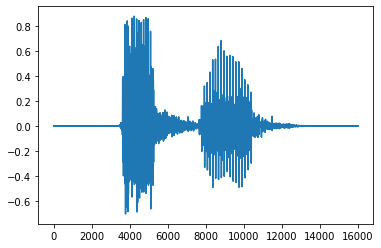

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [ ]:
sample_rate


48000

In [ ]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

play_audio(waveform, sample_rate)

Resampling

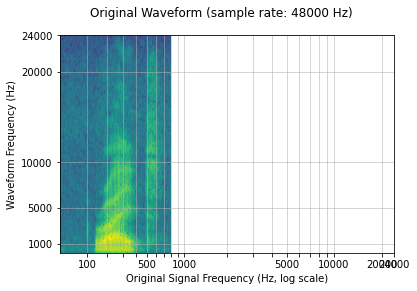

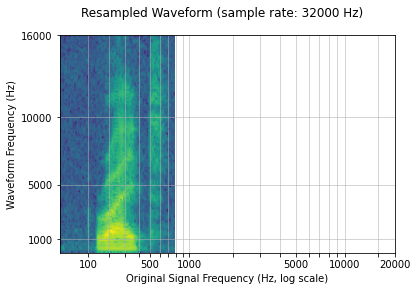

In [ ]:
#Checking the resampling quality. The sample_rate of the data is 4800
DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)
  
sample_rate = 48000
resample_rate = 32000

#waveform = get_sine_sweep(sample_rate)
plot_sweep(waveform, sample_rate, title="Original Waveform")
play_audio(waveform, sample_rate)

resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)
plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
play_audio(waveform, sample_rate)

#Data augmentation

Applying effects and filtering 

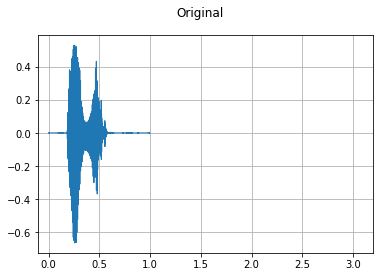

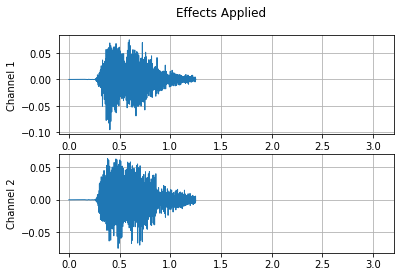

----------
Source: Original
----------
Sample Rate: 16000
Shape: (1, 16000)
Dtype: torch.float32
 - Max:      0.529
 - Min:     -0.664
 - Mean:    -0.000
 - Std Dev:  0.071

tensor([[ 0.0000e+00, -9.1553e-05, -3.0518e-05,  ...,  3.0518e-05,
         -1.2207e-04, -2.1362e-04]])

----------
Source: Effects Applied
----------
Sample Rate: 16000
Shape: (2, 20000)
Dtype: torch.float32
 - Max:      0.075
 - Min:     -0.095
 - Mean:    -0.000
 - Std Dev:  0.016

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0002, -0.0003, -0.0003],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0013, -0.0016, -0.0019]])



In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


# Load the data
waveform, sample_rate

# Define effects
effects = [
  ["lowpass", "-1", "300"], # apply single-pole lowpass filter
  ["speed", "0.8"],  # reduce the speed
                     # This only changes sample rate, so it is necessary to
                     # add `rate` effect with original sample rate after this.
  ["rate", f"{sample_rate}"],
  ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    waveform, sample_rate, effects)

plot_waveform(waveform, sample_rate, title="Original", xlim=(-.1, 3.2))
plot_waveform(waveform2, sample_rate2, title="Effects Applied", xlim=(-.1, 3.2))
print_stats(waveform, sample_rate=sample_rate, src="Original")
print_stats(waveform2, sample_rate=sample_rate2, src="Effects Applied")

The new waveforms have 2 channels and not one. That can create bugs because the new shape is (2,2000) and not (1,1600) as it was before.

# Feature extractions

###Spectrogram

To get the frequency representation of audio signal, i can use Spectrogram transform.

Shape: (1, 513, 32)
Dtype: torch.float32
 - Max:     1767.877
 - Min:      0.000
 - Mean:     1.867
 - Std Dev: 25.747

tensor([[[1.5741e-05, 4.8483e-08, 1.9502e-05,  ..., 8.2093e-06,
          4.3003e-06, 4.4451e-07],
         [5.0012e-05, 8.2936e-06, 4.7065e-05,  ..., 3.8513e-05,
          3.0311e-06, 1.8492e-05],
         [7.1862e-05, 5.0254e-05, 1.9045e-05,  ..., 1.8424e-04,
          6.7433e-05, 6.2142e-05],
         ...,
         [1.3240e-07, 1.3664e-07, 2.9898e-09,  ..., 9.5296e-08,
          2.3993e-09, 1.6627e-07],
         [9.5641e-07, 1.3589e-07, 1.4710e-08,  ..., 3.4736e-08,
          1.3258e-07, 1.6921e-07],
         [1.7692e-06, 2.8035e-07, 2.5234e-08,  ..., 1.9489e-08,
          1.7324e-07, 6.8057e-07]]])



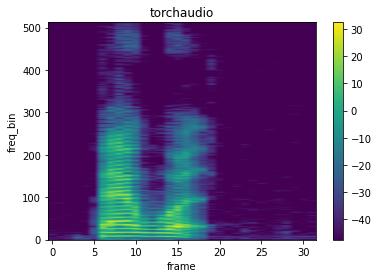

In [ ]:
#Now i need to extract the spectogram from each file. These and the label are the data to be fed to neural Network, that consists of Conv1D, LSTM and BiDirectional

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  #change to decibel
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

waveform, sample_rate, label, speaker_id, utterance_number = train_set[10]
waveform
sample_rate

n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    #Fourier Transform
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

Spectogram list

In [ ]:
spectogram_list = []

for i in tqdm(range(64_747)):
  waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
  waveform = (waveform - waveform.mean()) / waveform.std()
  #spectogram_list.append((spectrogram(waveform), label))
  spectogram_list.append((spectrogram(waveform)))

spectogram_list

Normalize also the spectogram?

In [ ]:
spect_norm = (spec - spec.mean()) / spec.std()
spect_norm

In [ ]:
plot_spectrogram(spect_norm[0], title='torchaudio')

Normalizing the spectograms requires other features techniques such as to step through the training set and find the mean and standard deviation of each mini-batch. Then we average all the mini-batch statistics to get a single pair of (𝜇,𝜎) normalization statistics. I'm not familiar with this yet so i will continue without normalizing the spectograms.

#Mel Filter Bank
torchaudio.functional.create_fb_matrix can generate the filter bank to convert frequency bins to Mel-scale bins.

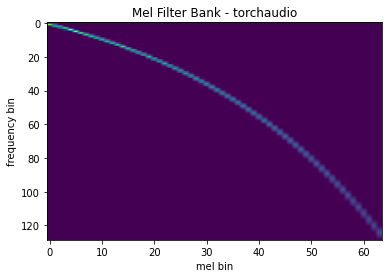

In [ ]:
#Since this function does not require input audio/features, there is no equivalent transform in torchaudio.transforms.
#MAYBE IT GOES OUT
def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)
  
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters =torchaudio.functional.create_fb_matrix(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.,
    f_max=sample_rate/2.,
    sample_rate=sample_rate,
    norm='slaney'
)
plot_mel_fbank(mel_filters, "Mel Filter Bank - torchaudio")


#MelSpectrogram
Mel-scale spectrogram is a combination of Spectrogram and mel scale conversion. In torchaudio, there is a transform MelSpectrogram which is composed of Spectrogram and MelScale.

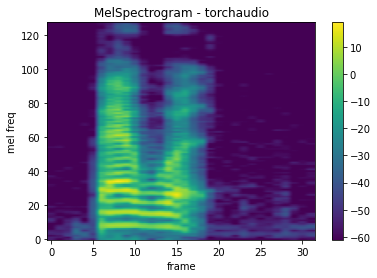

In [ ]:
waveform, sample_rate 

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')


In [ ]:
 melspec.shape

torch.Size([1, 128, 32])

mel spectogram tensor -> n_mels, sample rate , fft_size

In [ ]:
mel_spectogram_list = []

for i in range(64_747):
  waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
  waveform = (waveform - waveform.mean()) / waveform.std()
  mel_spectogram_list.append((mel_spectrogram(waveform), label))
mel_spectogram_list

[(tensor([[[1.5496e+01, 1.9524e+02, 4.2929e+02,  ..., 8.7284e+00,
            1.7248e+02, 4.1024e+02],
           [3.8688e+00, 9.7259e+01, 1.5132e+02,  ..., 2.7743e+01,
            1.1723e+02, 8.7304e+01],
           [3.0970e+00, 2.0773e+01, 2.6702e+01,  ..., 5.0211e+01,
            4.3092e+01, 3.8962e+01],
           ...,
           [2.7885e-03, 1.1034e-03, 1.2200e-03,  ..., 7.5741e-04,
            1.4870e-03, 3.9908e-03],
           [7.2344e-04, 1.2109e-03, 9.4925e-04,  ..., 8.0535e-04,
            5.9425e-04, 1.2161e-03],
           [4.0984e-04, 3.2984e-04, 6.9453e-04,  ..., 6.2190e-04,
            8.3409e-04, 3.2910e-04]]]), 'backward'),
 (tensor([[[1.0131e-04, 4.4938e-04, 2.0914e-03,  ..., 3.4173e-04,
            1.9971e-03, 2.9248e-03],
           [3.5464e-03, 7.1867e-04, 3.4598e-04,  ..., 2.4216e-03,
            1.3215e-03, 1.8777e-03],
           [4.1433e-03, 2.3603e-04, 7.4841e-04,  ..., 1.3164e-03,
            1.7608e-03, 1.1388e-03],
           ...,
           [4.6779e-05, 4

In [ ]:
mel_spectrogram

MelSpectrogram(
  (spectrogram): Spectrogram()
  (mel_scale): MelScale()
)

Plot some melspectograms with their labels

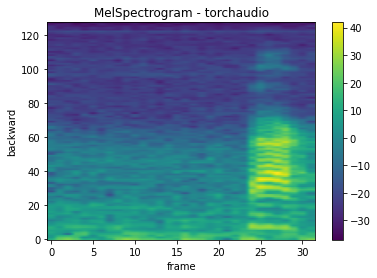

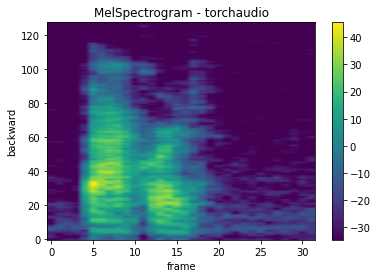

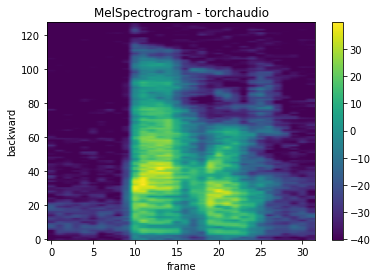

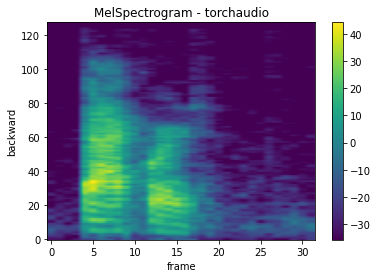

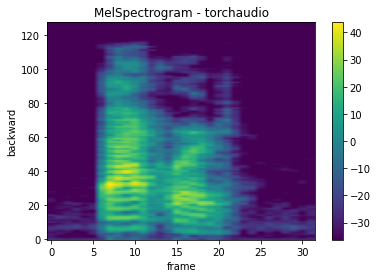

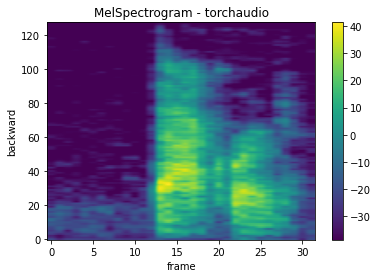

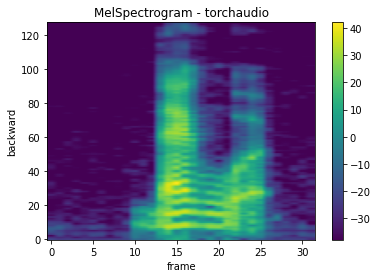

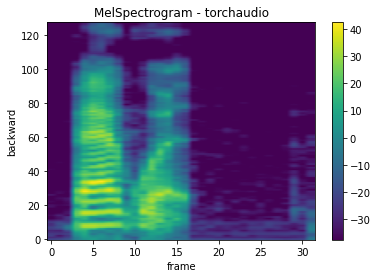

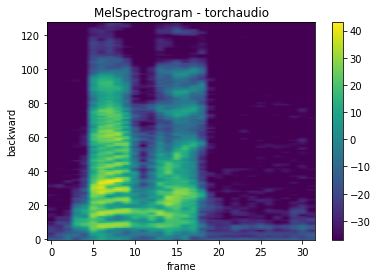

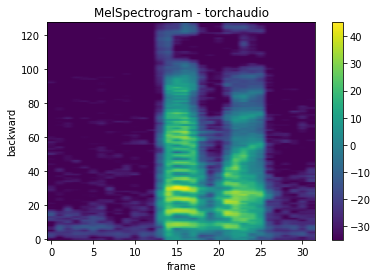

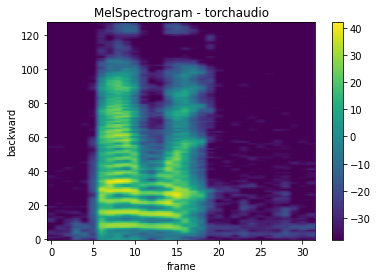

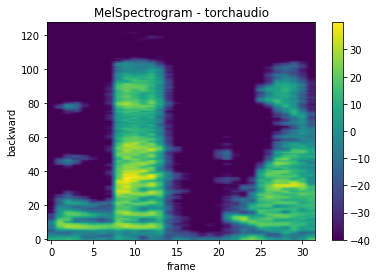

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
for i, (melspec, label) in enumerate(mel_spectogram_list):
    plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel=label)

Extracting the MFFC features

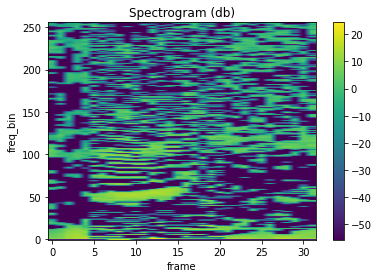

In [ ]:

waveform, sample_rate 

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform, sample_rate)

plot_spectrogram(mfcc[0])


Pitch Shifting

It is an implementation of pitch scaling used in musical instruments. It is a process of changing the pitch of sound without affect it’s speed.

*Pitch is a perceptual property of sounds that allows their ordering on a frequency-related scale, or more commonly, pitch is the quality that makes it possible to judge sounds as "higher" and "lower" in the sense associated with musical melodies.

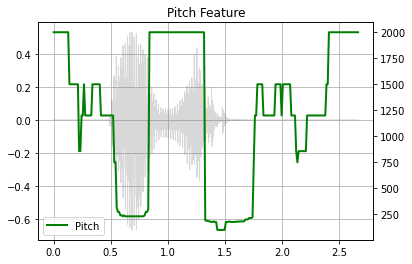

In [ ]:

import torchaudio.functional as F

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

waveform, sample_rate

pitch = F.detect_pitch_frequency(waveform, sample_rate)
plot_pitch(waveform, sample_rate, pitch)
play_audio(waveform, sample_rate)


#Feature Extractions


#TimeMasking
Here i have weird results
Is my spec ok?

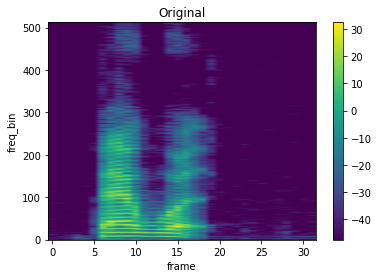

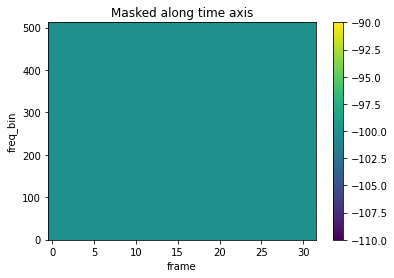

In [ ]:


torch.random.manual_seed(4)

spec 
plot_spectrogram(spec[0], title="Original")

masking = T.TimeMasking(time_mask_param=80)
spec_ = masking(spec)

plot_spectrogram(spec_[0], title="Masked along time axis")


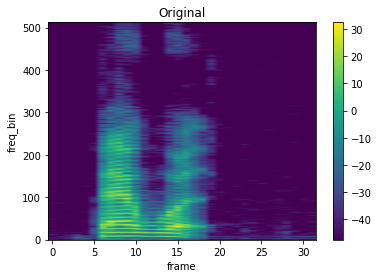

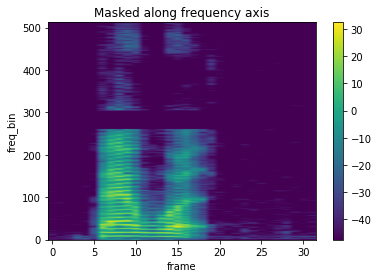

In [ ]:
#FrequencyMasking

torch.random.manual_seed(4)

spec 
plot_spectrogram(spec[0], title="Original")

masking = T.FrequencyMasking(freq_mask_param=80)
spec_ = masking(spec)

plot_spectrogram(spec_[0], title="Masked along frequency axis")
